In [1]:
import data
import models
import cache
import pandas as pd
import seaborn as sns

/home/jacquelineburos/miniconda3/envs/immuneinf/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "
INFO:stancache.seed:Setting seed to 1245502385
INFO:root:Setting CACHE_DIR = /mnt/modelcache/immune-infiltrate-explorations
INFO:stancache.seed:Setting seed to 1245502385


In [2]:
model_name = 'model6.2'
by = 'SubSet'
sample_n = 100 ## number genes
test_sample_n = 1 ## number out of sample samples
train_sample_n = None

In [3]:
sample_df = cache.cached(models.prep_sample_df,
                         sample_n=sample_n)

(training_df, test_df) = cache.cached(
    models.split_sample_df,
    sample_df=sample_df,
    test_sample_n=test_sample_n,
    train_sample_n=train_sample_n)

INFO:stancache.stancache:prep_sample_df: cache_filename set to prep_sample_df.cached.sample_n_100.pkl
INFO:stancache.stancache:prep_sample_df: Loading result from cache
INFO:stancache.stancache:split_sample_df: cache_filename set to split_sample_df.cached.sample_df_98115729811.test_sample_n_1.train_sample_n_82429761595.pkl
INFO:stancache.stancache:split_sample_df: Loading result from cache


In [4]:
model_file = models.get_model_file(model_name=model_name)
#print(cache._read_file(model_file))

In [5]:
stan_data = models.prep_stan_data(sample_df=training_df, test_df=test_df, by=by)

In [6]:
model_fit = models.cached_stan_fit(file=model_file,
                                   data=stan_data,
                                   model_name=model_name,
                                   iter=10000)

INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to model6_2.cython_0_25_1.model_code_15105066910483198602.pystan_2_12_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Loading result from cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to model6_2.cython_0_25_1.model_code_15105066910483198602.pystan_2_12_0_0.stanfit.chains_4.data_34263011054.iter_10000.seed_1245502385.pkl
INFO:stancache.stancache:sampling: Loading result from cache


## inspect posterior predictions

First, we note that the model didn't converge very well. We should probably diagnose fit of the model better.

In [7]:
models.print_stan_summary(model_fit, pars='lp__')

              mean     se_mean          sd          2.5%           50%         97.5%    Rhat
lp__  4.208759e+07  386.580341  546.707162  4.208688e+07  4.208741e+07  4.208863e+07  2.9823


However, the estimates for our sample2_x, which indicates mixing proportions of different types of cells, are somewhat better. Not great, but better.

In [8]:
models.print_stan_summary(model_fit, pars='sample2_x')

                     mean   se_mean        sd      2.5%       50%     97.5%      Rhat
sample2_x[0,0]   0.046590  0.011181  0.037084  0.001659  0.041246  0.147726  1.130993
sample2_x[0,1]   0.053017  0.005800  0.033820  0.004829  0.048625  0.130539  1.114296
sample2_x[0,2]   0.061439  0.032970  0.065941  0.002937  0.036643  0.257905  1.543746
sample2_x[0,3]   0.101658  0.015871  0.074444  0.007385  0.084111  0.286775  1.182432
sample2_x[0,4]   0.087898  0.027773  0.078554  0.005089  0.053127  0.312522  1.245045
sample2_x[0,5]   0.055733  0.004765  0.037519  0.004806  0.054786  0.146858  1.082599
sample2_x[0,6]   0.103025  0.022063  0.066188  0.001655  0.105617  0.271632  1.206308
sample2_x[0,7]   0.131067  0.040110  0.098248  0.007001  0.112501  0.308440  1.430057
sample2_x[0,8]   0.081408  0.034522  0.077194  0.002777  0.046250  0.290318  1.287636
sample2_x[0,9]   0.110078  0.045623  0.091246  0.001882  0.093479  0.279650  1.522884
sample2_x[0,10]  0.078594  0.018206  0.060382  0.00730

These values `[0, x]` refer to the `[sample_id, subset_id]`. We only have one test sample, so this is fairly easy to interpret. 

Our subset_ids are indexed by the columns of the `stan_data['x']` object we passed in. 

In [9]:
colnames = list(stan_data['x'].columns)
colnames

['SubSet[B_CD5]',
 'SubSet[B_Memory]',
 'SubSet[B_Naive]',
 'SubSet[CD4_Central_Memory]',
 'SubSet[CD4_Effector_Memory]',
 'SubSet[CD4_Naive]',
 'SubSet[CD4_Th1]',
 'SubSet[CD4_Th17]',
 'SubSet[CD4_Th2]',
 'SubSet[CD4_Treg]',
 'SubSet[CD8_Central_Memory]',
 'SubSet[CD8_Effector]',
 'SubSet[CD8_Naive]']

We can re-use the code we wrote for `extract_theta_summary` to extract these values, since the data structure of `sample2_x` & of theta are similar. 

In [30]:
inferred_type = models.extract_theta_summary(colnames=colnames, par='sample2_x', stan_fit=model_fit, gene_id='sample_id')

We then reshape & format our desired "subset" variable. 

In [31]:
import re
df = pd.melt(inferred_type, id_vars=['iter','sample_id'], value_name='estimate', var_name='variable')
df['SubSet'] = df['variable'].apply(lambda x: re.sub(string=x, pattern='(.*)\[(.*)\]', repl='\\2'))


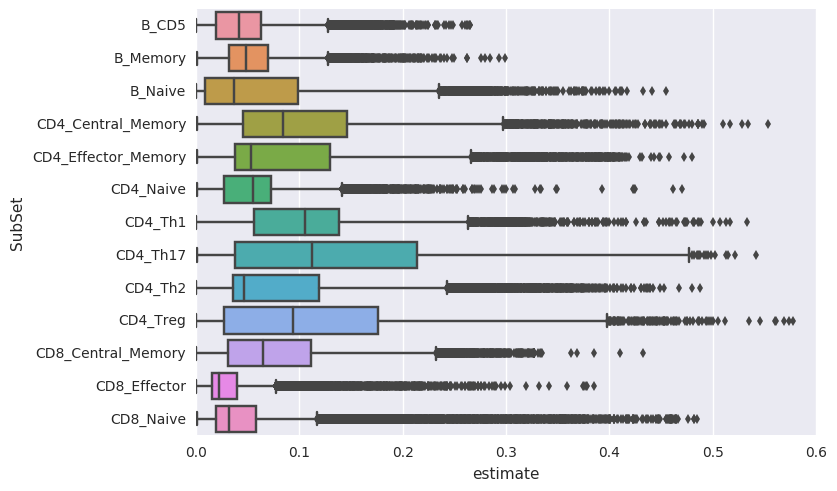

In [19]:
sns.boxplot(data=df, y='SubSet', x='estimate')

What is the "true" cell type?

In [13]:
test_df['SubSet'].unique()

array(['CD4_Treg'], dtype=object)

## summarize posterior predictions by cell_type

In [26]:
cell_types = sample_df.drop_duplicates(subset=['cell_type','SubSet']).loc[:,['cell_type','SubSet']]
df2 = pd.merge(cell_types, df, on='SubSet')
df2 = df2.groupby(['cell_type','iter']).agg({'estimate': sum}).reset_index()

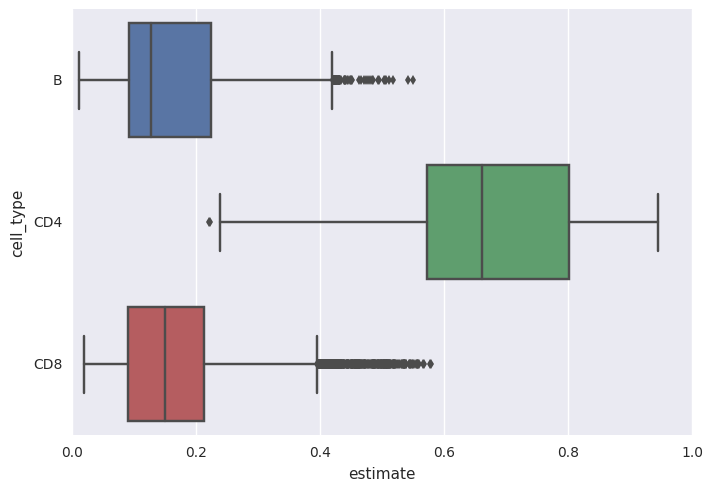

In [27]:
sns.boxplot(data=df2, y='cell_type', x='estimate')